In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
import csv
import numpy as np
import os
import tensorflow as tf
import zipfile
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

The data for this exercise is available at: https://www.kaggle.com/datamunge/sign-language-mnist/home

Sign up and download to find 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv -- You will upload both of them using this button before you can continue.


In [2]:
BASE_PATH="/data/tmp"
DATASETS_DIR="./datasets"
DATASET_NAME="sign-language-mnist.zip"
KAGGLE_DATASET="datamunge/sign-language-mnist"

In [3]:
# Kaggle Dataset Download :) 
def download_kaggle_dataset(dataset_name, path_to_download=DATASETS_DIR):
    print("Downloading at: {}".format(path_to_download))
    # --force if you want to force download
    !kaggle datasets download -d $dataset_name -p $path_to_download 

In [4]:
download_kaggle_dataset(KAGGLE_DATASET)

sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls $DATASET_DIR

Exercise_8_Question.ipynb  datasets  rock_paper_scissors.ipynb	tmp


In [6]:
def extract_dataset(filename, extract_dir=BASE_PATH):
    ''' will extract the dataset on the fullpath 
      to the extract_dir defined if not then default to BASE_PATH
      Args:
        filename (str): zip filename
        extract_dir (str): path to extract the zip file
    '''

    file_zip=os.path.join(DATASETS_DIR,filename)
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall(extract_dir)
    zip_ref.close()

In [7]:
# Filename without extension
name = os.path.splitext(os.path.basename(DATASET_NAME))[0]
# Base path + new dir 
new_dir = os.path.join(BASE_PATH, name)
# create the directory
try:
    os.mkdir(new_dir)
except FileExistsError:
    print("Directory {} already exist, so skipping creation".format(new_dir))
# extract the dataset
extract_dataset(filename=DATASET_NAME, extract_dir=new_dir)

Directory /data/tmp/sign-language-mnist already exist, so skipping creation


In [18]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contains 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
    fullpath = os.path.join(BASE_PATH, name, filename)
    # read csv as pandas
    df = pd.read_csv(filepath_or_buffer=fullpath, skiprows=0, sep=",")
    classes = df['label'].unique()
    print("Number of classes: {}".format(len(classes)))
    print("Classes: {}".format(classes))
    # transform the dataset to be float type
    dataset = df.to_numpy(dtype='float')
    # get all the columns except the first as it will represent the image 
    pre_images = dataset[:,1:]
    # declare the list that will store the images
    images = []
    
    for img in pre_images:
        # transform the 784 pixels to be (1,28,28)
        image_data_as_array = np.array_split(img, 28)
        # add it to the list :) 
        images.append(image_data_as_array)
        
    labels, images = dataset[:,0], np.array(images)
    return images, labels




In [19]:
# Get data for training ready 
training_images, training_labels = get_data('sign_mnist_train.csv')
# Get data for testing ready
testing_images, testing_labels = get_data('sign_mnist_test.csv')

Number of classes: 24
Classes: [ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]
Number of classes: 24
Classes: [ 6  5 10  0  3 21 14  7  8 12  4 22  2 15  1 13 19 18 23 17 20 16 11 24]


In [10]:
# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [11]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

train_images = np.expand_dims(training_images, axis=3)
test_images = np.expand_dims(testing_images, axis=3)

print(train_images.shape)
print(test_images.shape)

# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [12]:
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  vertical_flip=True, 
                                  rotation_range=45,
                                  fill_mode='nearest')




In [13]:
# Create an image generator for Validation
validation_datagen = ImageDataGenerator(rescale=1./255)
    

In [14]:
# Create the generator for training and validation
batch_size = 32 
training_generator = train_datagen.flow(x=train_images, y=training_labels, batch_size=batch_size)

validation_generator = validation_datagen.flow(x=test_images, y=testing_labels, batch_size=batch_size)

In [33]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
INPUT_SHAPE = (28,28,1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=26, activation=tf.nn.softmax) # 26 alphabet letters
    ]
)

In [34]:
# Compile Model. I 
loss_function = tf.losses.SparseCategoricalCrossentropy()
optimizer_function = tf.keras.optimizers.Adam()

model.compile(loss=loss_function, 
              optimizer=optimizer_function,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [36]:
# Train the Model
steps_per_epoch = train_images.shape[0] / batch_size
validation_steps = test_images.shape[0] / batch_size

history = model.fit_generator(generator=training_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              epochs=10,
                              verbose=2)

Epoch 1/10
858/857 - 36s - loss: 1.8910 - sparse_categorical_accuracy: 0.4044 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.6414
Epoch 2/10
858/857 - 36s - loss: 0.9626 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.7559
Epoch 3/10
858/857 - 42s - loss: 0.6592 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.5599 - val_sparse_categorical_accuracy: 0.8116
Epoch 4/10
858/857 - 40s - loss: 0.5104 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.5222 - val_sparse_categorical_accuracy: 0.8352
Epoch 5/10
858/857 - 37s - loss: 0.4001 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.4301 - val_sparse_categorical_accuracy: 0.8525
Epoch 6/10
858/857 - 40s - loss: 0.3476 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.4073 - val_sparse_categorical_accuracy: 0.8546
Epoch 7/10
858/857 - 39s - loss: 0.2983 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8632
Epoch 8/10
858/857 - 41s - 

In [38]:
model.evaluate(test_images, testing_labels)
    
# The output from model.evaluate should be close to:
[6.92426086682151, 0.56609035]

7172/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[6.92426086682151, 0.56609035]

In [41]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [42]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



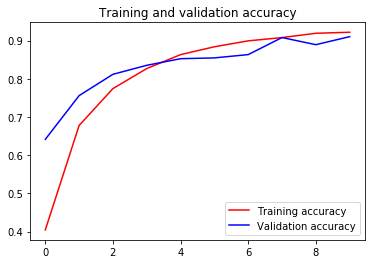

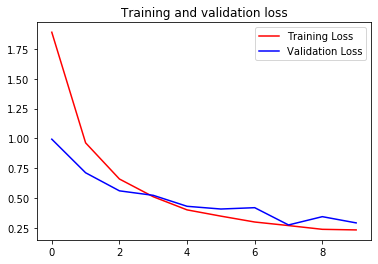

In [43]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()